In [ ]:
# Kernel fails unless:
# Source: https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
platform = "laptop"
decode_strategy = "top_p"
model_type = "gpt-j-6b"
model_input_fname = '3shot_10fold_test'
model_output_results_fname = '3shot_10fold_test-gpt-j-6B-20221201-143539'
num_outputs = 10
nshot = model_input_fname[0]
topp = 0.3
topk = 0
temp = 1


In [ ]:
# Relevant directories
model_inputs_directory = "C:\\Users\\sbnr014\\OneDrive - City, University of London\Documents\\GitHub\\MSc-thesis\\1. Data prep\\3. Prompt engineering\\8. FS & US prompts with FS & US examples\\Test\\"
model_outputs_directory = "W:\\SP&P\\Billy\\MSc Data Science\\6. Modules\\8. INM363 Individual Project\\2. NLP - Code & Viz generation\\13. Results\Test sets\\Research objective 2\\"

# Mount Google Drive

In [ ]:
# Mount google drive if platform
if platform == 'colab':

    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')

    # Cd to relevant google drive directory
    # Note: Run a shell command using os.system
    import os
    os.chdir('/content/drive/MyDrive/Colab Notebooks/Final project/2. Models/1. Transformer-based LM/1. Autoregressive LMs/2. Top-K')

# Import dependencies

In [ ]:
# from save_load import save_compressed, load_compressed, load_pickle, set_directories
from save_load import load_pickle, load_compressed, save_pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import altair as alt
import IPython.display
import random
import ast
import numpy as np
import json
import scipy
import os

# Directories

In [ ]:
# Print variables and directoripromptes
print("Model:", model_type)
print("Platform:", platform)
print("\n")
print("Model inputs file name:", model_input_fname)
print("Model inputs directory:", model_inputs_directory)
print("\n")
print("Model outputs file names:", model_output_results_fname)
print("Model outputs directory:", model_outputs_directory)
print("\n")
print("Decoding strategy:", decode_strategy)

Model: gpt-j-6b
Platform: laptop


Model inputs file name: 3shot_10fold_test
Model inputs directory: C:\Users\sbnr014\OneDrive - City, University of London\Documents\GitHub\MSc-thesis\1. Data prep\3. Prompt engineering\8. FS & US prompts with FS & US examples\Test\


Model outputs file names: 3shot_10fold_test-gpt-j-6B-20221201-143539
Model outputs directory: W:\SP&P\Billy\MSc Data Science\6. Modules\8. INM363 Individual Project\2. NLP - Code & Viz generation\13. Results\Test sets\Research objective 2\


Decoding strategy: top_p


# Load data

## Model inputs

In [ ]:
# Model inputs
# columns = ['query', 'viz_type', 'query_type', 'dataset', 'dataset_url', 'metaData', 'spec', 'marktype', 'context', 'prompt', 'input']
columns = ['query', 'query_type', 'dataset', 'dataset_url', 'metaData', 'spec', 'marktype', 'context', 'prompt', 'input']
model_inputs = load_pickle(model_inputs_directory + model_input_fname + '.pickle')
model_inputs = pd.DataFrame.from_records(model_inputs, columns=columns)
model_inputs['spec'] = model_inputs['spec'].str.replace('nan', 'None') # Replace nan with None (this enables coversion from str to dict) later
print(model_inputs.shape)
model_inputs.head()

(160, 10)


,query,query_type,dataset,dataset_url,metaData,spec,marktype,context,prompt,input
0,show me average budget split by content rating...,Under specified,movies,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Title, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,bar,Generate a vega-lite specification for the tas...,Task: Using data from https://raw.githubuserco...,Generate a vega-lite specification for the tas...
1,"Histogram of running time, in 20 minute bands",Fully specified,movies,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Title, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,bar,Generate a vega-lite specification for the tas...,Task: Using data from https://raw.githubuserco...,Generate a vega-lite specification for the tas...
2,show me horsepower vs acceleration,Under specified,cars,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Model, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,point,Generate a vega-lite specification for the tas...,Task: Using data from https://raw.githubuserco...,Generate a vega-lite specification for the tas...
3,Product Single Order Quantity Trend,Under specified,superstore,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Days to Ship, type: quantita...",{'$schema': 'https://vega.github.io/schema/veg...,bar,Generate a vega-lite specification for the tas...,Task: Using data from https://raw.githubuserco...,Generate a vega-lite specification for the tas...
4,give me a scatterplot of imdb rating as x axis...,Fully specified,movies,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Title, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,point,Generate a vega-lite specification for the tas...,Task: Using data from https://raw.githubuserco...,Generate a vega-lite specification for the tas...


## Model outputs

In [ ]:
# Parsed and validated model outputs
model_outputs = load_compressed(model_outputs_directory + model_output_results_fname + '_validated')
print(model_outputs.keys())
print(len(model_outputs['Validated spec']))
print(len(model_outputs['Validated spec'][0]))

dict_keys(['Inference time', 'Decoded sequences', 'Parsed spec', 'Validated spec'])
160
10


# Reshape

## Target specifications

In [ ]:
target_specs = model_inputs[['spec']].copy(deep=True)
target_specs['spec'] = target_specs['spec'].apply(lambda x: ast.literal_eval(x))  # Convert str to dict
target_specs = pd.concat([target_specs for n in range(num_outputs)], axis=1, ignore_index=True)  # Duplicate target columns - number of outputs per problem
target_specs.head()

,0,1,2,3,4,5,6,7,8,9
0,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
1,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
2,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
3,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
4,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...


## Raw model outputs

In [ ]:
# Raw model outputs
raw_model_outputs = model_outputs['Decoded sequences']
raw_model_outputs = pd.DataFrame(raw_model_outputs, columns = list(range(num_outputs)))
raw_model_outputs.head()

,0,1,2,3,4,5,6,7,8,9
0,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...
1,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...
2,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...
3,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...
4,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...,<|endoftext|><|endoftext|><|endoftext|><|endof...


## Parsed model outputs

In [ ]:
# Parsed model outputs
parsed_model_outputs = model_outputs['Parsed spec']
parsed_model_outputs = pd.DataFrame(parsed_model_outputs, columns = list(range(num_outputs)))
parsed_model_outputs.head()

,0,1,2,3,4,5,6,7,8,9
0,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
1,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
2,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
3,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
4,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...


## Validated model outputs

In [ ]:
# Validated model outputs
validated_model_outputs = model_outputs['Validated spec']
validated_model_outputs = pd.DataFrame(validated_model_outputs, columns = list(range(num_outputs)))
validated_model_outputs.head()

,0,1,2,3,4,5,6,7,8,9
0,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
1,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
2,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
3,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...
4,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...,{'$schema': 'https://vega.github.io/schema/veg...


# Update error terminology

In [ ]:
# Validated model outputs
validated_model_outputs = validated_model_outputs.applymap(lambda x: "Validation error" if x=="Schema error" else x)
validated_model_outputs = validated_model_outputs.applymap(lambda x: "Syntax error" if x=="Type error" else x)
validated_model_outputs = validated_model_outputs.applymap(lambda x: "Syntax error" if x=="Value error" else x)

In [ ]:
# Parsed model outputs
parsed_model_outputs = parsed_model_outputs.applymap(lambda x: "Syntax error" if x=="Type error" else x)
parsed_model_outputs = parsed_model_outputs.applymap(lambda x: "Syntax error" if x=="Value error" else x)

# Characterise test set

In [ ]:
print(f"Number of problems: {model_inputs.shape[0]}")

Number of problems: 160


In [ ]:
# Mark type
train_mtype_summary = pd.DataFrame(dict(count=model_inputs.loc[:, 'marktype'].value_counts(
), perc=model_inputs.loc[:, 'marktype'].value_counts(normalize=True)))
train_mtype_summary

,count,perc
bar,83,0.51875
point,50,0.31250
line,25,0.15625
area,1,0.00625
tick,1,0.00625


In [ ]:
# Data source
train_dsource_summary = pd.DataFrame(dict(count=model_inputs.loc[:, 'dataset'].value_counts(
), perc=model_inputs.loc[:, 'dataset'].value_counts(normalize=True)))
train_dsource_summary

,count,perc
cars,57,0.35625
movies,56,0.35000
superstore,45,0.28125
euro,2,0.01250


In [ ]:
# Query type
train_type_summary = pd.DataFrame(dict(count=model_inputs.loc[:, 'query_type'].value_counts(
), perc=model_inputs.loc[:, 'query_type'].value_counts(normalize=True)))
train_type_summary

,count,perc
Under specified,102,0.6375
Fully specified,58,0.3625


# Validate Vega-Lite schema

## Valid@1 as a function of hyper-parameters
Valid@1 = The fraction of problems where the model generates a valid specification in 1 sample

### Functions

In [ ]:
# Function: Calculate the average fraction of problems where the model passes a given test in 1 sample across all parameter sets
def pass1_summary(df):
    """ Summarise pass@1 and error rates for all sets of hyper-parameters in a gridsearch.
    Applicable to results generated by both Top-K and Top-P decoding"""

    df = df.applymap(lambda x: 'Pass' if isinstance(x, dict) else x)
    df = df.apply(pd.Series.value_counts).apply(
            lambda x: x/x.sum()).transpose()

    df.insert(loc=0, column='n-shot', value=nshot)
    if decode_strategy == "top_p":
        df.insert(loc=0, column='Top-P', value= topp)
    df.insert(loc=0, column='Top-K', value= topk)
    df.insert(loc=0, column='Softmax T', value= temp)
#     df.rename(columns={'Pass': '% Pass'}, inplace=True)

    # Save output
    save_pickle(model_outputs_directory + model_output_results_fname + "_pass1_validation_summary.pickle", df)

    return df

In [ ]:
# Function: Top-K gridsearch surface plots via explicit method
def plot_errors(table):
    """ Plot a bar chart displaying the validation rate, attribute error rate, syntax error rate and validation error rate"""

    table.reset_index(inplace=True)
    labels = [col for col in table.columns.tolist() if col not in [
        'Softmax T', 'Top-K', 'Top-P', 'n-shot', 'Pass count', 'Invalid count']]
    table = table.loc[0, labels]
    table = table.reset_index()
    table = table.iloc[1:, :]
    table = table.sort_values(by=[0], ascending=False)
    X = table['index'].tolist()
    Y = [y*100 for y in table[0].tolist()]

    # Set style temporarily using style context manager
    # Source: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
    with plt.style.context(['seaborn-bright', 'C:\\Users\\sbnr014\\OneDrive - City, University of London\\Documents\\GitHub\\MSc-thesis\\4. Test set\\dev.mplstyle']):
        fig, axes = plt.subplots(nrows=1,
                                 ncols=1)

        axes.bar(X, Y)
        axes.set_ylabel('% of total')
        axes.set_ylim([0, 100])
        plt.xticks(rotation=45)

#             axes.grid(True)
#             plt.show()
    plt.show()
    plt.close()

### Analyses

In [ ]:
# Summary
pass1_test_summary = pass1_summary(validated_model_outputs)
pass1_test_summary.head()

,Softmax T,Top-K,Top-P,n-shot,Pass,Syntax error,Validation error
0,1,0,0.3,3,0.91875,0.00625,0.075
1,1,0,0.3,3,0.91875,0.00625,0.075
2,1,0,0.3,3,0.91875,0.00625,0.075
3,1,0,0.3,3,0.91875,0.00625,0.075
4,1,0,0.3,3,0.91875,0.00625,0.075


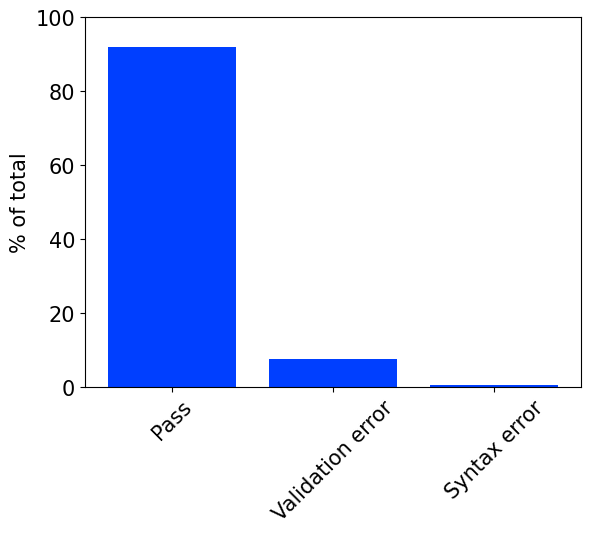

In [ ]:
# Compare errors
plot_errors(pass1_test_summary)

## Valid@k as a function of hyper-parameters
Valid@100 = The fraction of problems where the model generates a valid specification in 100 samples

### Functions

In [ ]:
# Function: Calculate the average fraction of problems where the model passes a given test
def passk_summary(df, k):
    """ Summarise pass@k and error rates for a gridsearch.
    Applicable to results generated by both Top-K and Top-P decoding"""

    df = df.applymap(lambda x: 'Pass' if isinstance(x, dict) else x)

    # Valid
    count_valid = df == 'Pass'
    count_valid = ((count_valid.iloc[:, :10] == True).sum(axis=1) > 0).sum()
    perc_valid = count_valid / df.shape[0]

    # Invalid
    count_invalid = df.shape[0]-count_valid
    perc_invalid = 1-perc_valid

    # Output
    df = pd.DataFrame({"Pass": perc_valid, "Pass count": count_valid, "Fail": perc_invalid, "Fail count": count_invalid}, index=[k])

    # # Save output
    save_pickle(model_outputs_directory + model_output_results_fname + "_passk_validation_summary.pickle", df)

    return df

In [ ]:
def plot_valid1_vs_validk(pass1, passk):
    """Compare pass1 and passk rates"""

    X = ['valid@1', 'valid@k']
    Y1 = pass1.loc[0, 'Pass']
    Y2 = passk.loc[10, 'Pass']
    Y = [Y1*100, Y2*100]

    # Set style temporarily using style context manager
    # Source: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
    with plt.style.context(['seaborn-bright', 'C:\\Users\\sbnr014\\OneDrive - City, University of London\\Documents\\GitHub\\MSc-thesis\\4. Test set\\dev.mplstyle']):
        fig, axes = plt.subplots(nrows=1,
                                 ncols=1)
        axes.scatter(X, Y, s=1000, marker='+')
        axes.set_ylabel('% of total')
        axes.set_ylim([90, 100])
        axes.set_xlim([-0.5, 1.5])
        plt.xticks(rotation=45)
    #             axes.grid(True)
        plt.show()
        plt.close()

### Analyses

In [ ]:
# Pass@K
passk_test_summary = passk_summary(validated_model_outputs, num_outputs)
passk_test_summary

,Pass,Pass count,Fail,Fail count
10,0.91875,147,0.08125,13


## Valid@1 versus Valid@k

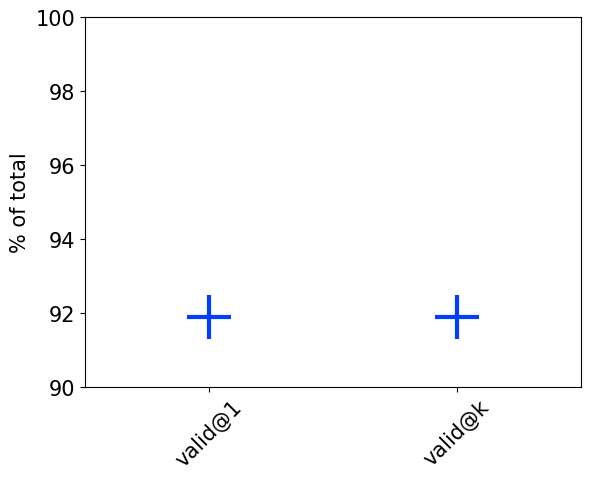

In [ ]:
# Valid@1 versus Valid@k
plot_valid1_vs_validk(pass1_test_summary, passk_test_summary)

# Logic validation

https://vega.github.io/vega-lite/docs/transform.html

1. Is the visualisation's data source correct?
"Vega-Lite’s data property describes the visualization’s data source as part of the specification, which can be either inline data (values) or a URL from which to load the data (url)."

2. Are the data transformations valid?
"Data transformations in Vega-Lite are described via either view-level transforms (the transform property) or field transforms inside encoding (bin, timeUnit, aggregate, sort, and stack)."

3. Is the mark type correct?


3. Is data mapped to the correct visual properties?

"They provide basic shapes whose properties (such as position, size, and color) can be used to visually encode data, either from a data field, or a constant value."

* Is the mark type valid?
* Are correct data transformations applied?
* Are the same encodings provided (





* Is it the correct mark type?
* Are the same encodings provided (mark properties, facet, order)?
* Are encodings linked to the same fields?
* Are the correct aggregation function or filters applied?


A set of questions

## Functions

In [ ]:
# Function: Assess generated specifications against target specifications using a specified rule

def assess_rule(df, rule_func, *args):
    """Assess results using a given rule"""
    output = {}

    for col, row_result in df.to_dict().items():
        col_output = {col: {}}

        for row, result in row_result.items():
            if isinstance(result, dict):
                col_output[col].update(
                    {row: rule_func(result, row, col, *args)})
            else:
                col_output[col].update({row: result})

        output.update(col_output)

    return pd.DataFrame.from_dict(output)

In [ ]:
# Functions: Rules for comparing generated specifications against target specifications

def data_source_rule(test_spec, row, column):
    return test_spec.get('data').get('url') == target_specs.iloc[row, column]['data']['url']


def mark_type_rule(test_spec, row, column):

    if 'mark' in target_specs.iloc[row, column] and 'mark' in test_spec:
        return test_spec.get('mark').get('type') == target_specs.iloc[row, column]['mark']['type']

    elif 'mark' not in target_specs.iloc[row, column] and 'mark' not in test_spec:
        return test_spec['hconcat'][0].get('mark') == target_specs.iloc[row, column]['hconcat'][0]['mark']

    else:
        return 1 == 2


def granular_encoding_rule(test_spec, row, column, *args):

    relevant_channels, relevant_keys = args

    # Test spec - Create a set of relevant values for the chosen channels
    if 'encoding' in test_spec:
        test_spec_values = {outer_key: {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys}
                            for outer_key, outer_value in test_spec['encoding'].items() if outer_key in relevant_channels}
    elif 'hconcat' in test_spec:
        test_spec_values = {outer_key: {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys}
                            for outer_key, outer_value in test_spec['hconcat'][0]['encoding'].items() if outer_key in relevant_channels}
    else:
        test_spec_values = {}

    # Target spec - Create a set of relevant values for the chosen channels
    if 'encoding' in target_specs.iloc[row, column]:
        target_spec_values = {outer_key: {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys}
                              for outer_key, outer_value in target_specs.iloc[row, column]['encoding'].items() if outer_key in relevant_channels}

    else:
        target_spec_values = {outer_key: {inner_key: inner_value for inner_key, inner_value in outer_value.items() if inner_key in relevant_keys}
                              for outer_key, outer_value in target_specs.iloc[row, column]['hconcat'][0]['encoding'].items() if outer_key in relevant_channels}

    # Target spec - Replace any 'mean' values for aggregate with 'average'
    for outer_key, outer_value in target_spec_values.items():
        for inner_key, inner_value in outer_value.items():
            if inner_value == 'mean':
                target_spec_values[outer_key][inner_key] = 'average'

    # Test spec - Replace any 'mean' values for aggregate with 'average'
    for outer_key, outer_value in test_spec_values.items():
        for inner_key, inner_value in outer_value.items():
            if inner_value == 'mean':
                test_spec_values[outer_key][inner_key] = 'average'

    # Test spec - create sets containing (field, aggregation function) frozen sets
    test_spec_values = [tuple(outer_value.values())
                        for outer_key, outer_value in test_spec_values.items()]

    test_spec_values = {tuple(json.dumps(element) if isinstance(
        element, dict) else element for element in t) for t in test_spec_values}

    test_spec_values = {frozenset(t) for t in test_spec_values}

    # Target spec - create sets containing (field, aggregation function) frozen sets
    target_spec_values = [tuple(outer_value.values())
                          for outer_key, outer_value in target_spec_values.items()]

    target_spec_values = {tuple(json.dumps(element) if isinstance(
        element, dict) else element for element in t) for t in target_spec_values}

    target_spec_values = {frozenset(t) for t in target_spec_values}


    # Remove field in (field, aggregate function) frozen set if the aggregate function is count
    if frozenset({'count'}) in target_spec_values:
        test_spec_values = set([frozenset({'count'}) if 'count' in s else s for s in list(test_spec_values)])

    # Remove aggregate function in (field, aggregate function) frozen set if the aggregate function is None
    test_spec_values = [[v for v in list(s) if v is not None] for s in list(test_spec_values)]
    test_spec_values = set([frozenset(s) for s in test_spec_values])

    target_spec_values = [[v for v in list(s) if v is not None] for s in list(target_spec_values)]
    target_spec_values = set([frozenset(s) for s in target_spec_values])

    return test_spec_values == target_spec_values

In [ ]:
# Function: Calculate the average fraction of problems where the model passes a given test in 1 sample

def pass1_unit_test_summary(df):
    """ Summarise pass@1 and error rates after application of a specific unit test.
    Applicable to results generated by both Top-K and Top-P decoding"""

    count_valid = (df == True).sum()
    perc_valid = (df == True).sum()/df.count()

    df = pd.DataFrame({"Pass": perc_valid,
                       "Pass count": count_valid,
                       'n-shot': nshot,
                       'Top-P': topp,
                       'Top-K': topk},
                      index=[0])

    # # Save output
    save_pickle(model_outputs_directory + model_output_results_fname + "_pass1_unit_test_summary.pickle", df)

    return df

In [ ]:
# Function: Calculate the average fraction of problems where the model passes a given test across the entire hyper-parameter space

def passk_unit_test_summary(df, k):
    """ Summarise pass@k and error rates after application of a specific unit test.
    Applicable to results generated by both Top-K and Top-P decoding"""

    count_valid = ((df.iloc[:, :k] == True).sum(axis=1) > 0).sum()
    perc_valid = count_valid / df.shape[0]

    df = pd.DataFrame({"Pass": perc_valid,
                       "Pass count": count_valid,
                       'n-shot': nshot,
                       'Top-P': topp,
                       'Top-K': topk},
                      index=[k])

    # # Save output
    save_pickle(model_outputs_directory + model_output_results_fname + "_passk_unit_test_summary.pickle", df)

    return df

In [ ]:
def pass1_logic_q_results(unit_test_results):
    """Insert a flag indicating whether a specification has passed all unit tests (i.e. logic validation) """

    unit_test_passes = [df.applymap(
        lambda x: x if x == True else np.nan) for df in unit_test_results]

    # Compare all unit test results to the first test - return True if all True
    # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
    output_passed_all = unit_test_results[0].copy(deep=True)

    for row in range(unit_test_passes[0].shape[0]):
        for col in range(unit_test_passes[0].shape[1]):
            output_passed_all.iloc[row, col] = all(unit_test_passes[0].iloc[row, col] == x for x in [
                                                   df.iloc[row, col] for df in unit_test_passes])

    # Save
    save_pickle(model_outputs_directory + model_output_results_fname + "_pass1_logic_q_results.pickle", output_passed_all)

    return output_passed_all

In [ ]:
def pass1_logic_summary(unit_test_results):
    """ Summarise pass@1 and error rates for all sets after application of a set of unit tests.
    Applicable to results generated by both Top-K and Top-P decoding"""

    # Pass %
    unit_test_passes = [df.applymap(
        lambda x: x if x == True else np.nan) for df in unit_test_results]
    output_passed_all = unit_test_results[0].copy(deep=True)

    # Compare all unit test results to the first test - return True if all True
    # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
    for row in range(unit_test_passes[0].shape[0]):
        for col in range(unit_test_passes[0].shape[1]):
            output_passed_all.iloc[row, col] = all(unit_test_passes[0].iloc[row, col] == x for x in [
                                                   df.iloc[row, col] for df in unit_test_passes])

    perc_pass = (output_passed_all == True).sum()/output_passed_all.count()

    # Logic error %
    unit_test_fails = [df.applymap(
        lambda x: True if x == False else False) for df in unit_test_results]
    output_failed_any = unit_test_results[0].copy(deep=True)

    # Compare all unit test results to the first test - return True if any True
    # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
    for row in range(unit_test_fails[0].shape[0]):
        for col in range(unit_test_fails[0].shape[1]):
            output_failed_any.iloc[row, col] = any(
                [df.iloc[row, col] for df in unit_test_fails])

    perc_logic = (output_failed_any == True).sum()/output_failed_any.count()

    # Create data frame
    df = pd.DataFrame({"Pass": perc_pass,
                       "Logic error": perc_logic,
                       'n-shot': nshot,
                       'Top-P': topp,
                       'Top-K': topk},
                      index=[0])
    # # Save output
    save_pickle(model_outputs_directory + model_output_results_fname + "_pass1_logic_summary.pickle", df)
    return df

In [ ]:
def passk_logic_summary(unit_test_results, k):
    """ Summarise pass@k and error rates after application of a set of unit tests.
    Applicable to results generated by both Top-K and Top-P decoding"""

    # Pass %
    output_passed_all = unit_test_results[0].copy(deep=True)
    test_results = [df.applymap(lambda x: x if x == True else np.nan)
                    for df in unit_test_results]

    # Compare all unit test results to the first test
    # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
    for row in range(test_results[0].shape[0]):
        for col in range(test_results[0].shape[1]):
            output_passed_all.iloc[row, col] = all(test_results[0].iloc[row, col] == x
                                                   for x in [df.iloc[row, col] for df in test_results])

    count_valid = (
        (output_passed_all.iloc[:, :k] == True).sum(axis=1) > 0).sum()
    perc_valid = count_valid / output_passed_all.shape[0]

    # Create data frame
    df = pd.DataFrame({"Pass": perc_valid,
                       "Pass count": count_valid,
                       'n-shot': nshot,
                       'Top-P': topp,
                       'Top-K': topk},
                      index=[k])

    # # Save output
    save_pickle(model_outputs_directory + model_output_results_fname + "_passk_logic_summary.pickle", df)

    return df

In [ ]:
def plot_final_errors(validation_pass1, logic_pass1):
    """Compare pass rate before and after logical unit tests"""

    validation_labels = [c for c in validation_pass1.columns if c not in [
        'index', 'Softmax T', 'Top-K', 'Top-P', 'n-shot', 'Pass']]

    data = pd.concat([validation_pass1.loc[[0], validation_labels],
                      logic_pass1.loc[[0], ['Pass', "Logic error"]]],
                     axis=1)

    data = data.sort_values(by=0, axis=1, ascending=False)
    print(data)

    X = [x.lstrip("% ") for x in data.columns.tolist()]
    Y = list(data.values.flatten())
    Y = [y*100 for y in Y]

    # Set style temporarily using style context manager
    # Source: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
    with plt.style.context(['seaborn-bright', 'C:\\Users\\sbnr014\\OneDrive - City, University of London\\Documents\\GitHub\\MSc-thesis\\4. Test set\\dev.mplstyle']):
        fig, axes = plt.subplots(nrows=1,
                                 ncols=1)

        axes.bar(X, Y)
        axes.set_ylabel('% of total')
        axes.set_ylim([0, 100])
        plt.xticks(rotation=45)
#             axes.grid(True)
    plt.show()
    plt.close()

## Verify data source
["*Vega-Lite’s data property describes the visualization’s data source as part of the specification, which can be either inline data (values) or a URL from which to load the data (url).*"](https://vega.github.io/vega-lite/docs/data.html)

### Pass@1

In [ ]:
# Pass1 Table
validated_dsource_outputs = assess_rule(validated_model_outputs, data_source_rule)
dsource_pass1_summary = pass1_unit_test_summary(validated_dsource_outputs)
dsource_pass1_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
0,0.91875,147,3,0.3,0


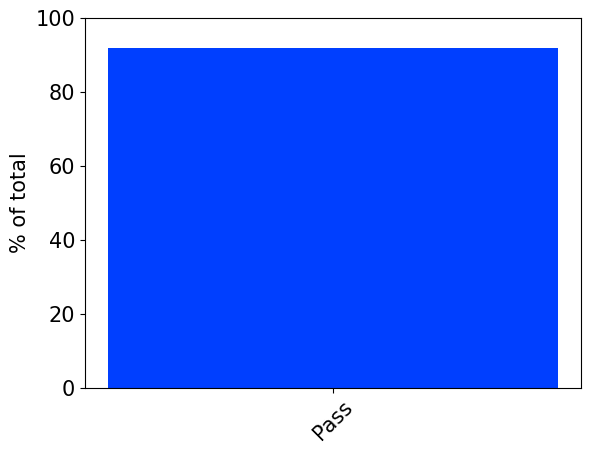

In [ ]:
# Pass1 Plot
plot_errors(dsource_pass1_summary)

### Pass@K

In [ ]:
# PassK Table
dsource_passk_summary = passk_unit_test_summary(validated_dsource_outputs, num_outputs)
dsource_passk_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
10,0.91875,147,3,0.3,0


## Verify mark type
["*Marks are the basic visual building block of a visualization. They provide basic shapes whose properties (such as position, size, and color) can be used to visually encode data, either from a data field, or a constant value. The mark property of a single view specification can either be (1) a string describing a mark type or (2) a mark definition object.*"](https://vega.github.io/vega-lite/docs/mark.html)

### Pass@1

In [ ]:
# Pass1 Table
validated_mtype_outputs = assess_rule(validated_model_outputs, mark_type_rule)
mtype_pass1_summary = pass1_unit_test_summary(validated_dsource_outputs)
mtype_pass1_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
0,0.91875,147,3,0.3,0


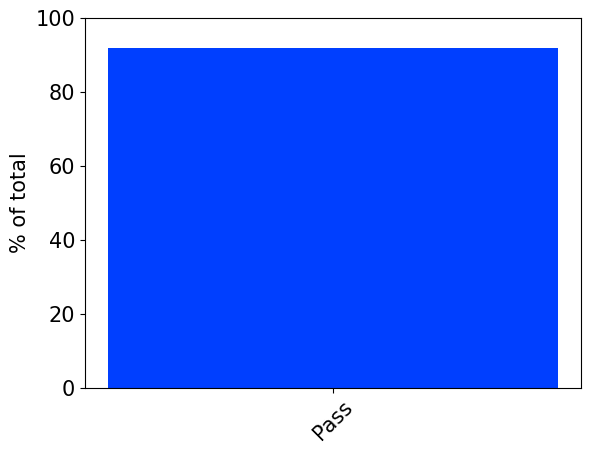

In [ ]:
# Pass1 Plot
plot_errors(mtype_pass1_summary)

### Pass@k

In [ ]:
# Pass1 Table
mtype_passk_summary = passk_unit_test_summary(validated_dsource_outputs, num_outputs)
mtype_passk_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
10,0.91875,147,3,0.3,0


## Verify data transformations
["*Data transformations in Vega-Lite are described via either view-level transforms (the transform property) or field transforms inside encoding (bin, timeUnit, aggregate, sort, and stack)*"](https://vega.github.io/vega-lite/docs/transform.html)


### Position channels

#### Pass@1

In [ ]:
# Pass1 Table
validated_pchannel_outputs = assess_rule(validated_model_outputs, granular_encoding_rule, ['x', 'y'], ['field', 'aggregate'])
pchannel_pass1_summary = pass1_unit_test_summary(validated_pchannel_outputs)
pchannel_pass1_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
0,0.8375,134,3,0.3,0


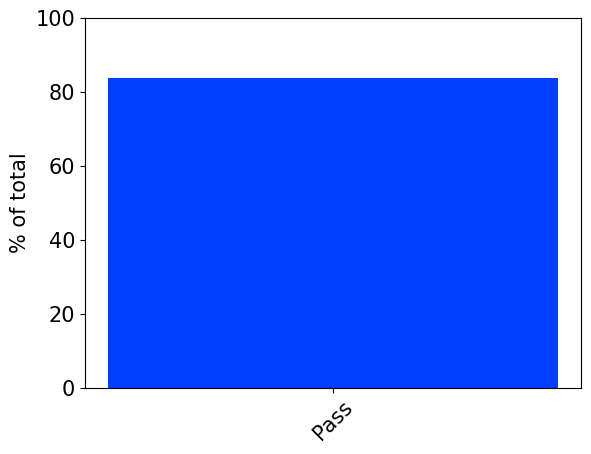

In [ ]:
# Pass1 Plot
plot_errors(pchannel_pass1_summary)

#### Pass@k

In [ ]:
# Passk Table
pchannel_passk_summary = passk_unit_test_summary(validated_pchannel_outputs, num_outputs)
pchannel_passk_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
10,0.8375,134,3,0.3,0


### Facet channels

#### Pass@1

In [ ]:
# Pass1 Table
validated_fchannel_outputs = assess_rule(validated_model_outputs, granular_encoding_rule, ['facet', 'row', 'column'], ['field', 'aggregate'])
fchannel_pass1_summary = pass1_unit_test_summary(validated_fchannel_outputs)
fchannel_pass1_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
0,0.8625,138,3,0.3,0


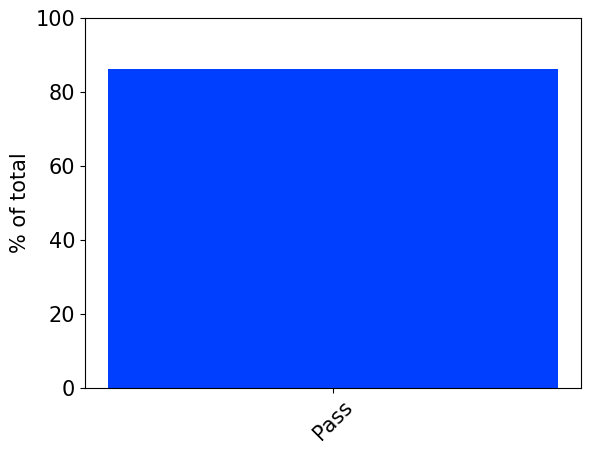

In [ ]:
# Pass1 Plot
plot_errors(fchannel_pass1_summary)

#### Pass@k

In [ ]:
# Passk Table
fchannel_passk_summary = passk_unit_test_summary(validated_fchannel_outputs, num_outputs)
fchannel_passk_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
10,0.8625,138,3,0.3,0


### Mark properties

#### Pass@1

In [ ]:
# Pass1 Table
validated_mchannel_outputs = assess_rule(validated_model_outputs, granular_encoding_rule, ['color'], ['field', 'aggregate'])
mchannel_pass1_summary = pass1_unit_test_summary(validated_mchannel_outputs)
mchannel_pass1_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
0,0.8625,138,3,0.3,0


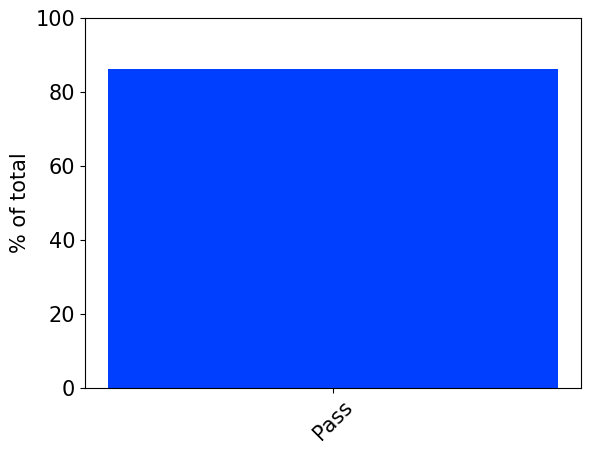

In [ ]:
# Pass1 Plot
plot_errors(mchannel_pass1_summary)

#### Pass@k

In [ ]:
# Passk Table
mchannel_passk_summary = passk_unit_test_summary(validated_mchannel_outputs, num_outputs)
mchannel_passk_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
10,0.8625,138,3,0.3,0


### Detail properties

#### Pass@1

In [ ]:
# Pass1 Table
validated_dchannel_outputs = assess_rule(validated_model_outputs, granular_encoding_rule, ['detail'], ['field', 'aggregate'])
dchannel_pass1_summary = pass1_unit_test_summary(validated_dchannel_outputs)
dchannel_pass1_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
0,0.91875,147,3,0.3,0


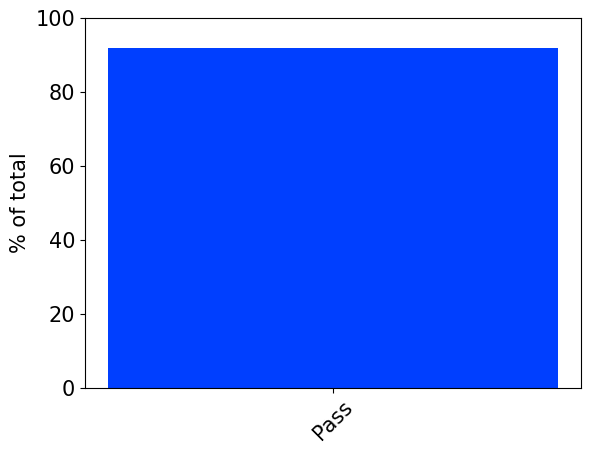

In [ ]:
# Pass1 Plot
plot_errors(dchannel_pass1_summary)

#### Pass@k

In [ ]:
# Passk Table
dchannel_passk_summary = passk_unit_test_summary(validated_dchannel_outputs, num_outputs)
dchannel_passk_summary.head()

,Pass,Pass count,n-shot,Top-P,Top-K
10,0.91875,147,3,0.3,0


### Compare unit test error rates

#### Functions

In [ ]:
def plot_logical_test_results(tests, pass1summary):
    """Compare pass rates across selected unit tests"""

    X = ['Data source', 'Mark type', 'Position channel', 'Facet channel', 'Mark channel', 'Detail channel']
    Y = [pass1_test_summary.loc[0,'Pass'] - x.loc[0,'Pass'] for x in tests]
    Y = [y*100 for y in Y]

    print(pd.DataFrame({'Type': X, '% of total': Y}))

    # Set style temporarily using style context manager
    # Source: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
    with plt.style.context(['seaborn-bright', 'C:\\Users\\sbnr014\\OneDrive - City, University of London\\Documents\\GitHub\\MSc-thesis\\4. Test set\\dev.mplstyle']):
        fig, axes = plt.subplots(nrows=1,
                                 ncols=1)
        axes.bar(X, Y)
        axes.set_ylabel('% of total')
        axes.set_ylim([0, 100])
        plt.xticks(rotation=45)
    #             axes.grid(True)
        plt.show()
        plt.close()

#### Analyses

               Type  % of total
0       Data source       0.000
1         Mark type       0.000
2  Position channel       8.125
3     Facet channel       5.625
4      Mark channel       5.625
5    Detail channel       0.000


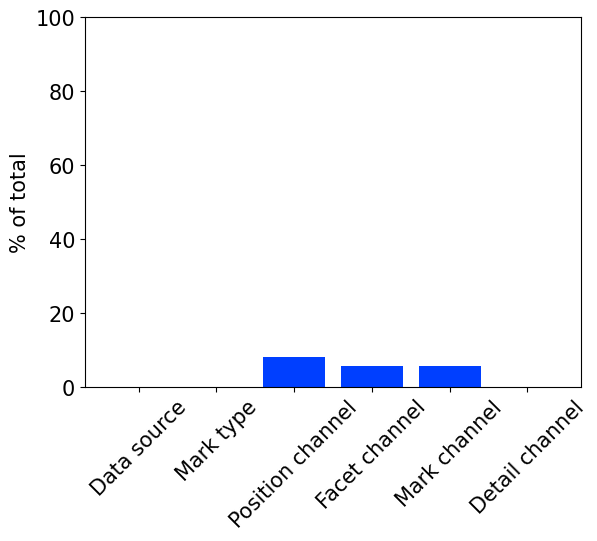

In [ ]:
unit_tests = [dsource_pass1_summary,
              mtype_pass1_summary,
              pchannel_pass1_summary,
              fchannel_pass1_summary,
              mchannel_pass1_summary,
              dchannel_pass1_summary]

plot_logical_test_results(unit_tests, pass1_test_summary)

# **Overall pass rate**

## Pass@1

In [ ]:
# Pass1 Table
unit_tests = [validated_dsource_outputs,
              validated_mtype_outputs,
              validated_pchannel_outputs,
              validated_fchannel_outputs,
              validated_mchannel_outputs,
              validated_dchannel_outputs]

# Save question level results
pass1_logic_q_results(unit_tests)

# Summarise results
fc_pass1_summary = pass1_logic_summary(unit_tests)
fc_pass1_summary.head()

,Pass,Logic error,n-shot,Top-P,Top-K
0,0.78125,0.1375,3,0.3,0


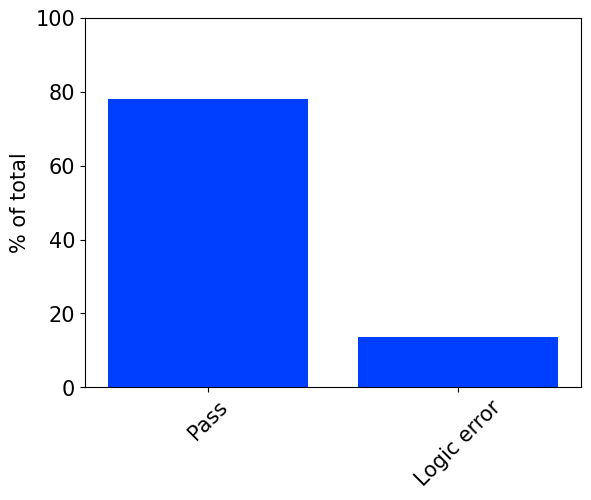

In [ ]:
# Compare final pass rate with logical errors
plot_errors(fc_pass1_summary)

      Pass  Logic error  Validation error  Syntax error
0  0.78125       0.1375             0.075       0.00625


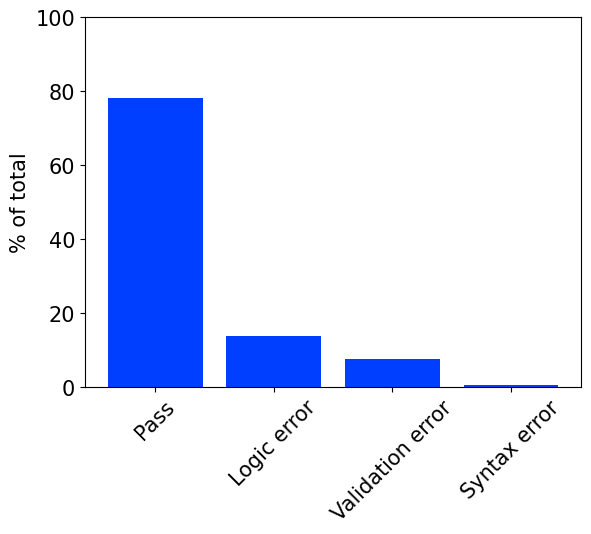

In [ ]:
# Compare all errors
plot_final_errors(pass1_test_summary, fc_pass1_summary)

## Pass@k

In [ ]:
# Pass@k
unit_tests = [validated_dsource_outputs,
              validated_mtype_outputs,
              validated_pchannel_outputs,
              validated_fchannel_outputs,
              validated_mchannel_outputs,
              validated_dchannel_outputs]

fc_passk_summary = passk_logic_summary(unit_tests, num_outputs)
fc_passk_summary

,Pass,Pass count,n-shot,Top-P,Top-K
10,0.78125,125,3,0.3,0


## Pass@1 versus Pass@k

In [ ]:
def plot_pass1_vs_passk(pass1, passk):
    """Compare pass1 and passk rates"""

    X = ['pass@1', 'pass@k']
    Y1 = pass1.loc[0, 'Pass']
    Y2 = passk.loc[10, 'Pass']
    Y = [Y1*100, Y2*100]

    # Set style temporarily using style context manager
    # Source: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
    with plt.style.context(['seaborn-bright', 'C:\\Users\\sbnr014\\OneDrive - City, University of London\\Documents\\GitHub\\MSc-thesis\\4. Test set\\dev.mplstyle']):
        fig, axes = plt.subplots(nrows=1,
                                 ncols=1)
        axes.scatter(X, Y, s=1000, marker='+')
        axes.set_ylabel('% of total')
        axes.set_ylim([70, 80])
        axes.set_xlim([-0.5, 1.5])
#         axes.grid(True)
        plt.xticks(rotation=45)
        plt.show()
        plt.close()

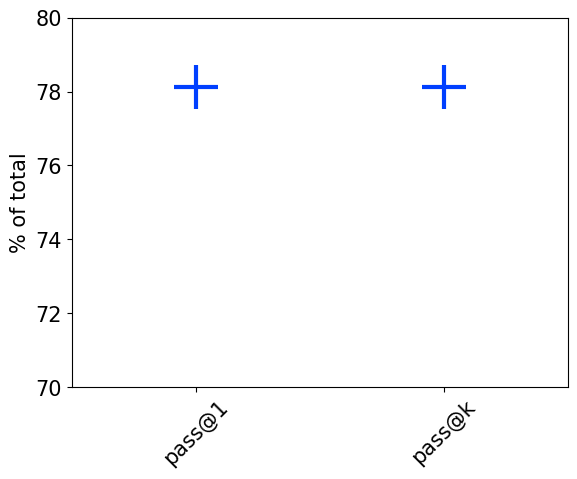

In [ ]:
# Pass@1 versus Pass@k
plot_pass1_vs_passk(fc_pass1_summary, fc_passk_summary)

# Precision & recall

In [ ]:
pass1_precision = fc_pass1_summary.loc[0, 'Pass'] / (
    fc_pass1_summary.loc[0, 'Pass'] + (pass1_test_summary.loc[0, 'Pass'] - fc_pass1_summary.loc[0, 'Pass']))
pass1_precision

0.8503401360544218

In [ ]:
passk_precision = fc_passk_summary.loc[10, 'Pass'] / (
    fc_passk_summary.loc[10, 'Pass'] + (passk_test_summary.loc[10, 'Pass'] - fc_passk_summary.loc[10, 'Pass']))
passk_precision

0.8503401360544218

# Hypothesis testing

In [ ]:
# def gs_pass1_pairedTT_summary(unit_test_results, parameters, n_1, n_2, topP_1, topP_2):
#     """ Calculate p-value using a paired t-test for a given number of in-context examples (n), and lower and upper threshold p.
#     unit_test_results = pass@1 and error rates for all sets of hyper-parameters after application of a set of unit tests.
#     Applicable to grid search results generated by both Top-K and Top-P decoding"""

#     # Grid search indexes
#     gs_index_1 = [outer_key for outer_key, outer_value in gptneo125m_parameters[n_1].items(
#     ) if outer_value['P'] == topP_1][0]
#     gs_index_2 = [outer_key for outer_key, outer_value in gptneo125m_parameters[n_2].items(
#     ) if outer_value['P'] == topP_2][0]

#     passes_1 = []
#     passes_2 = []

#     # Pass rate for first set of conditions
#     for kfold in unit_test_results[0][n_1].keys():

#         # Pass rate
#         passed_all = unit_test_results[0][n_1][kfold].copy(deep=True)
#         unit_test_passes = [r[n_1][kfold] for r in unit_test_results]
#         unit_test_passes = [df.applymap(
#             lambda x: x if x == True else np.nan) for df in unit_test_passes]

#         # Compare all unit test results to the first test - return True if all True
#         # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
#         for row in range(unit_test_passes[0].shape[0]):
#             for col in range(unit_test_passes[0].shape[1]):
#                 passed_all.iloc[row, col] = all(unit_test_passes[0].iloc[row, col] == x
#                                                 for x in [df.iloc[row, col] for df in unit_test_passes])
#         # Calculate pass %
#         passes_1.append((passed_all == True).sum()/passed_all.count())

#     # Pass rate for second set of conditions
#     for kfold in unit_test_results[0][n_2].keys():

#         # Pass rate
#         passed_all = unit_test_results[0][n_2][kfold].copy(deep=True)
#         unit_test_passes = [r[n_2][kfold] for r in unit_test_results]
#         unit_test_passes = [df.applymap(
#             lambda x: x if x == True else np.nan) for df in unit_test_passes]

#         # Compare all unit test results to the first test - return True if all True
#         # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
#         for row in range(unit_test_passes[0].shape[0]):
#             for col in range(unit_test_passes[0].shape[1]):
#                 passed_all.iloc[row, col] = all(unit_test_passes[0].iloc[row, col] == x
#                                                 for x in [df.iloc[row, col] for df in unit_test_passes])
#         # Calculate pass %
#         passes_2.append((passed_all == True).sum()/passed_all.count())

#     # Calculate overall pass rates
#     passes_1 = pd.concat(passes_1, axis=1)
#     passes_2 = pd.concat(passes_2, axis=1)

#     # Calculate T score
#     # Source: https://towardsdatascience.com/paired-t-test-to-evaluate-machine-learning-classifiers-1f395a6c93fa
#     # Source: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
#     # Source:
#     p1 = [x for x in passes_1.iloc[gs_index_1].tolist()]
#     p2 = [x for x in passes_2.iloc[gs_index_2].tolist()]
#     degree_freedom = len(p1)-1
#     diff = np.array([y - x for y, x in zip(p1, p2)])
#     sample_mean = sum(diff)/len(diff)
#     sd = np.sqrt(sum(np.square(diff-sample_mean))/(len(p1)-1))
#     t_statistic = (np.sqrt(len(p1))*sample_mean)/sd

#     # Calculate P value using two tailed test
#     # Source: https://www.statology.org/p-value-from-t-score-python/
#     p_value = scipy.stats.t.sf(abs(t_statistic), df=degree_freedom)*2

#     return p_value

In [ ]:
# # GPT-Neo-125M - T-test
# # Source: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
# # Source: https://towardsdatascience.com/paired-t-test-to-evaluate-machine-learning-classifiers-1f395a6c93fa
# # Source: https://medium.com/analytics-vidhya/using-the-corrected-paired-students-t-test-for-comparing-the-performance-of-machine-learning-dc6529eaa97f
# # Source: http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_kfold_cv/
# unit_tests = [gptneo125m_dsource_validation,
#               gptneo125m_mtype_validation,
#               gptneo125m_pchannel_validation,
#               gptneo125m_fchannel_validation,
#               gptneo125m_mchannel_validation,
#               gptneo125m_dchannel_validation]

# p_value = gs_pass1_pairedTT_summary(
#     unit_tests, gptneo125m_parameters, 2, 3, 0.5, 0.5)
# print(p_value)

# Render visualisations

## Functions

In [ ]:
def render_validated(df, n_samples):
    """ df = reshaped validated outputs
    n_samples = number of random samples to render"""

    # Filter valid specifications
    is_valid = df.copy(deep=True)
    is_valid = is_valid.isin(
        ['Attribute error', 'Schema error', 'Syntax error', 'Type error', 'Validation error', 'Value error']) == False
    samples = df[is_valid]

    # Filter out rows with NaN in first column
    samples = samples[samples[0].notna()]

    # Sample
    samples = random.sample(samples.index.tolist(), n_samples)

    # Render visualisations
    for problem in samples:
        print("------------------------------------------------------------------------------------------------------")
        print(f"Problem number: {problem}")
        print(f"\nQuery:\n")
        print(model_inputs.loc[problem, 'query'])

        print(f"\nVisualisation:\n")
        chart = alt.Chart(**validated_model_outputs.iloc[problem, 0])
        chart.display()
        print(f"Vega-lite specification:\n")
        print(validated_model_outputs.iloc[problem, 0])

In [ ]:
def render_logical(df, unit_test_results, n_samples):
    """ df = reshaped validated outputs
    unit_tests = list of results for relevant unit tests
    n_samples = number of random samples to render"""

    unit_test_passes = [df.applymap(
        lambda x: x if x == True else np.nan) for df in unit_test_results]

    # Compare all unit test results to the first test - return True if all True
    # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
    is_valid = unit_test_results[0].copy(deep=True)

    for row in range(unit_test_passes[0].shape[0]):
        for col in range(unit_test_passes[0].shape[1]):
            is_valid.iloc[row, col] = all(unit_test_passes[0].iloc[row, col] == x for x in [
                                          df.iloc[row, col] for df in unit_test_passes])

    # Filter out null values
    samples = df[is_valid]

    # Filter out rows with NaN in first column
    samples = samples[samples[0].notna()]

    # Sample
    samples = random.sample(samples.index.tolist(), n_samples)

    # Render samples
    for problem in samples:
        print("------------------------------------------------------------------------------------------------------")
        print(f"Problem number: {problem}")
        print(f"\nQuery:\n")
        print(model_inputs.loc[problem, 'query'])

        print(f"\nVisualisation:\n")
        chart = alt.Chart(**validated_model_outputs.iloc[problem, 0])
        chart.display()
        print(f"Vega-lite specification:\n")
        print(validated_model_outputs.iloc[problem, 0])

## Validated specifications

In [ ]:
# Render validated specifications
render_validated(validated_model_outputs, 5)

------------------------------------------------------------------------------------------------------
Problem number: 36

Query:

Plot IMDB rating against Rotten Tomatoes rating.

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.5, 'tooltip': None}, 'encoding': {'x': {'field': 'IMDB Rating', 'type': 'quantitative'}, 'y': {'field': 'Rotten Tomatoes Rating', 'type': 'quantitative'}}}
------------------------------------------------------------------------------------------------------
Problem number: 134

Query:

plot displacement by mpg', 'color by origin

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nl4dv/nl4dv/master/examples/assets/data/cars-w-year.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.8, 'tooltip': None}, 'encoding': {'x': {'field': 'Displacement', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'y': {'field': 'MPG', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'color': {'field': 'Origin', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 18

Query:

What is the total profit for each region, based on ship status?

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'transform': [], 'encoding': {'x': {'field': 'Region', 'type': 'ordinal'}, 'y': {'aggregate': 'sum', 'field': 'Profit', 'type': 'quantitative', 'axis': {'title': 'SUM (Profit)'}}, 'color': {'field': 'Ship Status', 'type': 'nominal', 'legend': {'title': 'Ship Status'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 83

Query:

Sort creative types by number of movies

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Creative Type', 'type': 'nominal', 'sort': {'encoding': 'y', 'order': 'descending'}}, 'y': {'aggregate': 'count', 'type': 'quantitative', 'axis': {'title': 'COUNT'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 99

Query:

scatterplot MPG vs Displacement separated by country

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.8, 'tooltip': None}, 'encoding': {'x': {'field': 'Displacement', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'y': {'field': 'MPG', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'color': {'field': 'Origin', 'type': 'nominal'}}}


## Logical specifications

In [ ]:
# Render logical specifications
unit_tests = [validated_dsource_outputs,
              validated_mtype_outputs,
              validated_pchannel_outputs,
              validated_fchannel_outputs,
              validated_mchannel_outputs,
              validated_dchannel_outputs]
try:
    render_logical(validated_model_outputs, unit_tests, 20)
except ValueError:
    pass

------------------------------------------------------------------------------------------------------
Problem number: 131

Query:

Create stacked column graph of worldwide gross by major genre by content rating

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Major Genre', 'type': 'nominal'}, 'y': {'aggregate': 'sum', 'field': 'Worldwide Gross', 'type': 'quantitative', 'axis': {'title': 'SUM (Worldwide Gross)', 'format': '~s'}}, 'color': {'field': 'Content Rating', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 16

Query:

show me the count of cars by country of origin in bar chart

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Origin', 'type': 'nominal', 'sort': {'encoding': 'y', 'order': 'descending'}}, 'y': {'aggregate': 'count', 'type': 'quantitative', 'axis': {'title': 'COUNT'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 105

Query:

histogram for creative type

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Creative Type', 'type': 'nominal'}, 'y': {'aggregate': 'count', 'type': 'quantitative', 'axis': {'title': 'COUNT'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 20

Query:

Bar chart, x axis origin, y axis count of rows

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Origin', 'type': 'nominal'}, 'y': {'aggregate': 'count', 'type': 'quantitative'}}}
------------------------------------------------------------------------------------------------------
Problem number: 44

Query:

chart count to country

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Origin', 'type': 'nominal', 'sort': {'encoding': 'y', 'order': 'descending'}}, 'y': {'aggregate': 'count', 'type': 'quantitative', 'axis': {'title': 'COUNT'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 118

Query:

Show me total sales by month for the two-year period between Jan 2016 and Dec 2017.

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'line', 'tooltip': None}, 'encoding': {'x': {'timeUnit': 'yearmonth', 'field': 'Order Date', 'type': 'temporal', 'axis': {'title': 'Order Date'}}, 'y': {'aggregate': 'sum', 'field': 'Sales Forecast', 'type': 'quantitative', 'axis': {'title': 'SUM (Sales Forecast)'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 98

Query:

show me a bar chart of count by order quantity

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'bin': True, 'field': 'Quantity', 'type': 'quantitative', 'axis': {'title': 'Order Quantity'}}, 'y': {'aggregate': 'count', 'type': 'quantitative', 'axis': {'title': 'COUNT'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 10

Query:

Avg(Poduction Budget) Grouped by Content Rating and sub-grouped by Creative Type

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'column': {'field': 'Content Rating', 'type': 'ordinal'}, 'x': {'field': 'Creative Type', 'scale': {}, 'type': 'nominal', 'axis': {'title': '', 'labels': False, 'ticks': False}}, 'y': {'aggregate': 'mean', 'field': 'Production Budget', 'type': 'quantitative', 'axis': {'title': 'AVG (Production Budget)', 'format': '~s'}}, 'color': {'field': 'Creative Type', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 49

Query:

On average, how much was earned by movies of each genre?

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Major Genre', 'type': 'nominal'}, 'y': {'aggregate': 'mean', 'field': 'Worldwide Gross', 'type': 'quantitative', 'axis': {'title': 'AVG (Worldwide Gross)', 'format': '~s'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 99

Query:

scatterplot MPG vs Displacement separated by country

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.8, 'tooltip': None}, 'encoding': {'x': {'field': 'Displacement', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'y': {'field': 'MPG', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'color': {'field': 'Origin', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 74

Query:

Relationship between IMDB Rating and Rotten Tomatoes Rating

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.5, 'tooltip': None}, 'encoding': {'x': {'field': 'IMDB Rating', 'type': 'quantitative'}, 'y': {'field': 'Rotten Tomatoes Rating', 'type': 'quantitative'}}}
------------------------------------------------------------------------------------------------------
Problem number: 150

Query:

Scatter plot, x axis Displacement, Y axis MPG, Color by Origin

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.8, 'tooltip': None}, 'encoding': {'x': {'field': 'Displacement', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'y': {'field': 'MPG', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'color': {'field': 'Origin', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 78

Query:

show me how each rating, broken down by creative type, affects the average production budget

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'column': {'field': 'Content Rating', 'type': 'ordinal'}, 'x': {'field': 'Creative Type', 'scale': {}, 'type': 'nominal', 'axis': {'title': '', 'labels': False, 'ticks': False}}, 'y': {'aggregate': 'mean', 'field': 'Production Budget', 'type': 'quantitative', 'axis': {'title': 'AVG (Production Budget)', 'format': '~s'}}, 'color': {'field': 'Creative Type', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 24

Query:

line graph of worldwide gross for each genre for each year starting in 1995 to present

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'line', 'tooltip': None}, 'encoding': {'x': {'timeUnit': 'year', 'field': 'Release Year', 'type': 'temporal', 'axis': {'title': 'Release Year'}}, 'y': {'aggregate': 'sum', 'field': 'Worldwide Gross', 'type': 'quantitative', 'axis': {'title': 'SUM (Worldwide Gross)', 'format': '~s'}}, 'color': {'field': 'Major Genre', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 158

Query:

line chart of total worldwide gross over each release year, line for each genre

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'line', 'tooltip': None}, 'encoding': {'x': {'timeUnit': 'year', 'field': 'Release Year', 'type': 'temporal', 'axis': {'title': 'Release Year'}}, 'y': {'aggregate': 'sum', 'field': 'Worldwide Gross', 'type': 'quantitative', 'axis': {'title': 'SUM (Worldwide Gross)', 'format': '~s'}}, 'color': {'field': 'Major Genre', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 22

Query:

Draw axes for AVG(Horsepower) vs Year, colored by Origin

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'line', 'tooltip': None}, 'encoding': {'x': {'timeUnit': 'year', 'field': 'Year', 'type': 'temporal', 'axis': {'title': 'Year'}}, 'y': {'aggregate': 'mean', 'field': 'Horsepower', 'type': 'quantitative', 'axis': {'title': 'AVG (Horsepower)', 'format': '~s'}}, 'color': {'field': 'Origin', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 97

Query:

scatter plot of production budget vs worldwide gross, colored by genre

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.8, 'tooltip': None}, 'encoding': {'x': {'field': 'Production Budget', 'type': 'quantitative'}, 'y': {'field': 'Worldwide Gross', 'type': 'quantitative', 'axis': {'format': '~s'}}, 'color': {'field': 'Major Genre', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 0

Query:

show me average budget split by content rating colored by creative type

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/movies.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'column': {'field': 'Content Rating', 'type': 'ordinal'}, 'x': {'field': 'Creative Type', 'scale': {}, 'type': 'nominal', 'axis': {'title': '', 'labels': False, 'ticks': False}}, 'y': {'aggregate': 'mean', 'field': 'Production Budget', 'type': 'quantitative', 'axis': {'title': 'AVG (Production Budget)', 'format': '~s'}}, 'color': {'field': 'Creative Type', 'type': 'nominal'}}}
------------------------------------------------------------------------------------------------------
Problem number: 137

Query:

Draw the axes for the average of Weight vs Year

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'line', 'tooltip': None}, 'encoding': {'x': {'timeUnit': 'year', 'field': 'Year', 'type': 'temporal', 'axis': {'title': 'Year'}}, 'y': {'aggregate': 'mean', 'field': 'Weight', 'type': 'quantitative', 'axis': {'title': 'AVG (Weight)', 'format': '~s'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 2

Query:

show me horsepower vs acceleration

Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.7, 'tooltip': None}, 'encoding': {'x': {'field': 'Horsepower', 'type': 'quantitative'}, 'y': {'field': 'Acceleration', 'type': 'quantitative'}}}


# Print invalid specifications

## Functions

In [ ]:
def print_attribute_errors(raw_df, validated_df, n_samples):
    """ raw_df = raw unparsed reshaped model outputs
    validated_df = reshaped validated outputs
    n_samples = number of random samples to render"""

    # Filter invalid specifications
    is_invalid = validated_df.copy(deep=True)
    is_invalid = is_invalid.isin(
        ['Attribute error'])

    # Filter out rows with NaN in first column
    samples = validated_df[is_invalid]
    samples = samples[samples[0].notna()]

    # Sample
    samples = random.sample(samples.index.tolist(), n_samples)

    # Print
    for problem in samples:
        print("------------------------------------------------------------------------------------------------------")
        print(f"Problem number: {problem}")
        print(f"\nQuery:\n")
        print(model_inputs.loc[problem, 'query'])
        print(f"\nRaw output:\n")
        print(raw_df.iloc[problem, 0])

In [ ]:
def print_syntax_errors(parsed_df, validated_df, n_samples):
    """ raw_df = raw unparsed reshaped model outputs
    validated_df = reshaped validated outputs
    n_samples = number of random samples to render"""

    # Filter invalid specifications
    is_invalid = validated_df.copy(deep=True)
    is_invalid = is_invalid.isin(
        ['Syntax error', 'Type error', 'Value error'])

    # Filter out rows with NaN in first column
    samples = validated_df[is_invalid]
    samples = samples[samples[0].notna()]

    # Sample
    samples = random.sample(samples.index.tolist(), n_samples)

    # Print
    for problem in samples:
        print("------------------------------------------------------------------------------------------------------")
        print(f"Problem number: {problem}")
        print(f"\nQuery:\n")
        print(model_inputs.loc[problem, 'query'])
        print(f"\nParsed output:\n")
        print(parsed_df.iloc[problem, 0])

In [ ]:
def print_validation_errors(parsed_df, validated_df, n_samples):
    """ parsed_df = parsed reshaped model outputs
    validated_df = reshaped validated outputs
    n_samples = number of random samples to render"""

    # Filter invalid specifications
    is_invalid = validated_df.copy(deep=True)
    is_invalid = is_invalid.isin(
        ['Schema error', 'Validation error'])

    # Filter out rows with NaN in first column
    samples = validated_df[is_invalid]
    samples = samples[samples[0].notna()]

    # Sample
    samples = random.sample(samples.index.tolist(), n_samples)

    # Print
    for problem in samples:
        print("------------------------------------------------------------------------------------------------------")
        print(f"Problem number: {problem}")
        print(f"\nQuery:\n")
        print(model_inputs.loc[problem, 'query'])
        print(f"\nParsed output:\n")
        print(parsed_df.iloc[problem, 0])

In [ ]:
def print_nonlogical_specs(validated_df, unit_test, n_samples):
    """validated_df = reshaped validated outputs
    unit_test = results for a selected unit test
    n_samples = number of random samples to render"""

    # Filter invalid specifications
    is_invalid = unit_test.copy(deep=True)
    is_invalid = is_invalid.applymap(lambda x: True if x == False else False)

    # Filter out rows with NaN in first column
    samples = validated_df[is_invalid]
    samples = samples[samples[0].notna()]

    # Sample
    samples = random.sample(samples.index.tolist(), n_samples)

    # Print
    for problem in samples:
        print("------------------------------------------------------------------------------------------------------")
        print(f"Problem number: {problem}")
        print(f"\nQuery:\n")
        print(model_inputs.loc[problem, 'query'])
        print("\n")
        print(f"\nVisualisation:\n")
        chart = alt.Chart(**validated_model_outputs.iloc[problem, 0])
        chart.display()
        print(f"Vega-lite specification:\n")
        print(validated_model_outputs.iloc[problem, 0])
        print("\n")
        print(f"Target:\n")
        print(model_inputs.loc[problem, 'spec'])

## Attribute errors

In [ ]:
# Attribute
try:
    print_attribute_errors(raw_model_outputs, validated_model_outputs, 1)
except ValueError:
    pass

## Syntax errors

In [ ]:
# Syntax
try:
    print_syntax_errors(parsed_model_outputs, validated_model_outputs, 1)
except ValueError:
    pass

------------------------------------------------------------------------------------------------------
Problem number: 128

Query:

Bar chart scale -10000-50000 average profit vs. state all orders

Parsed output:

Syntax error


## Validation errors

In [ ]:
# Validation
try:
    print_validation_errors(parsed_model_outputs, validated_model_outputs, 5)
except ValueError:
    pass

------------------------------------------------------------------------------------------------------
Problem number: 130

Query:

show me distribution of gross as a strip plot

Parsed output:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'mark': {'type': 'tick', 'tooltip': True}, 'encoding': {'y': {'field': 'Worldwide Gross', 'type': 'quantitative', 'aggregate': None, 'axis': {'format': 's'}}, 'x': {'field': 'Genre', 'type': 'nominal', 'aggregate': None}, 'tooltip': {'field': 'Title'}}, 'transform': [], 'data': {'url': 'https://raw.githubusercontent.com/nl4dv/nl4dv/master/examples/assets/data/movies-w-year.csv', 'format': {'type': 'csv'}}}
------------------------------------------------------------------------------------------------------
Problem number: 106

Query:

show an area chart of how acceleration has evolved over the years across origin

Parsed output:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'mark': {'type': 'area', 'tool

## Logic errors

In [ ]:
# Non-logical specifications
# selected_test = validated_dsource_outputs
# selected_test = validated_mtype_outputs
# selected_test = validated_pchannel_outputs
# selected_test = validated_fchannel_outputs
selected_test = validated_mchannel_outputs
# selected_test = validated_dchannel_outputs

print_nonlogical_specs(validated_model_outputs, selected_test, 5)

------------------------------------------------------------------------------------------------------
Problem number: 68

Query:

How has horsepower changed over time by country?



Visualisation:



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'line', 'tooltip': None}, 'encoding': {'x': {'timeUnit': 'year', 'field': 'Year', 'type': 'temporal', 'axis': {'title': 'Year'}}, 'y': {'aggregate': 'mean', 'field': 'Horsepower', 'type': 'quantitative', 'axis': {'title': 'AVG (Horsepower)', 'format': '~s'}}, 'color': {'field': 'Country', 'type': 'nominal'}}}


Target:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'line', 'tooltip': None}, 'encoding': {'x': {'timeUnit': 'year', 'field': 'Year', 'type': 'temporal', 'axis': {'title': 'Year'}}, 'y': {'aggregate': 'mean', 'field': 'Horsepower', 'type': 'quantitative', 'axis': {'title': 'AVG (Horsepower)', 'format': '~s'}}, 'color':

alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.75, 'tooltip': None}, 'encoding': {'color': {'field': 'Region', 'type': 'nominal'}, 'x': {'field': 'Sales', 'type': 'quantitative'}, 'y': {'field': 'Profit', 'type': 'quantitative'}}}


Target:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.5, 'tooltip': None}, 'encoding': {'x': {'field': 'Profit', 'type': 'quantitative'}, 'y': {'field': 'Sales', 'type': 'quantitative'}}}
------------------------------------------------------------------------------------------------------
Problem number: 72

Query:

How many cars are from each region?



Vis

alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Origin', 'type': 'nominal'}, 'y': {'aggregate': 'count', 'type': 'quantitative', 'axis': {'title': 'COUNT', 'format': '~s'}}, 'color': {'field': 'Origin', 'type': 'nominal'}}}


Target:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/cars.csv'}, 'mark': {'type': 'bar', 'tooltip': None}, 'encoding': {'x': {'field': 'Origin', 'type': 'nominal', 'sort': {'encoding': 'y', 'order': 'descending'}}, 'y': {'aggregate': 'count', 'type': 'quantitative', 'axis': {'title': 'COUNT'}}}}
------------------------------------------------------------------------------------------------------
Problem number: 86

Query:

Cre

alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.5, 'tooltip': None}, 'encoding': {'column': {'field': 'Region', 'type': 'nominal'}, 'x': {'field': 'Sales', 'type': 'quantitative'}, 'y': {'field': 'Profit', 'type': 'quantitative'}}}


Target:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.75, 'tooltip': None}, 'encoding': {'color': {'field': 'Region', 'type': 'nominal'}, 'x': {'field': 'Sales', 'type': 'quantitative'}, 'y': {'field': 'Profit', 'type': 'quantitative'}}}
------------------------------------------------------------------------------------------------------
Problem number: 60



alt.Chart(...)

Vega-lite specification:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.75, 'tooltip': None}, 'encoding': {'color': {'field': 'Region', 'type': 'nominal'}, 'x': {'field': 'Sales', 'type': 'quantitative'}, 'y': {'field': 'Profit', 'type': 'quantitative'}}}


Target:

{'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json', 'data': {'url': 'https://raw.githubusercontent.com/nlvcorpus/nlvcorpus.github.io/main/datasets/superstore.csv'}, 'mark': {'type': 'point', 'filled': True, 'opacity': 0.5, 'tooltip': None}, 'encoding': {'column': {'field': 'Region', 'type': 'nominal'}, 'x': {'field': 'Sales', 'type': 'quantitative'}, 'y': {'field': 'Profit', 'type': 'quantitative'}}}


# Performance breakdowns

## Functions

In [ ]:
def validation_split(validated_df, split):
    """ validated_df = reshaped validated outputs
    split = marktype/dataset"""

    # Copy relevant validation set results
    df = validated_df.copy(deep=True)

    # Replace valid specifications with pass
    df = df.applymap(
        lambda x: 'Pass' if isinstance(x, dict) else x)

    # Aggregate syntax and validation errors
    df = df.applymap(lambda x: 'Syntax error' if x in [
                     'Syntax error', 'Type error', 'Value error'] else x)
    df = df.applymap(lambda x: 'Validation error' if x in [
                     'Validation error', 'Schema error'] else x)

    # Concatenate dataset/mark type
    df = pd.concat([df, model_inputs[split]], axis=1)

    # Count total number of values for each split
    error_counts = df.groupby([split, 0]).size().unstack(fill_value=0)
    error_counts = error_counts.fillna(0)
    error_counts = error_counts.groupby(level=0, axis=1).sum()

    # Calculate total number of problems for each split
    total_count = error_counts.sum(axis=1)

    # Calculate error rates for each split
    error_rates = error_counts.div(total_count, axis=0).add_suffix(" %")

    # Add total counts
    error_rates = pd.concat(
        [error_rates, error_counts, total_count.rename('Total')], axis=1)

    return error_rates

In [ ]:
def logical_split(validated_df, unit_test_results, split):
    """ Calculate functional pass rate by mark type or data source
    validated_df = reshaped validated outputs
    split = marktype/dataset
    unit_tests = list of unit test results"""

    unit_test_passes = [df.applymap(
        lambda x: x if x == True else np.nan) for df in unit_test_results]

    # Compare all unit test results to the first test - return True if all True
    # Source: https://towardsdatascience.com/python-tricks-check-multiple-variables-against-single-value-18a4d98d79f4
    is_valid = unit_test_results[0].copy(deep=True)

    for row in range(unit_test_passes[0].shape[0]):
        for col in range(unit_test_passes[0].shape[1]):
            is_valid.iloc[row, col] = all(unit_test_passes[0].iloc[row, col] == x for x in [
                                          df.iloc[row, col] for df in unit_test_passes])

    # Concatenate dataset/mark type
    df = pd.concat([is_valid, model_inputs[split]], axis=1)

    # Count total number of values for each split
    error_counts = df.groupby([split, 0]).size().unstack(fill_value=0)
    error_counts = error_counts.fillna(0)
    error_counts = error_counts.groupby(level=0, axis=1).sum()
    error_counts = error_counts.rename({True: "Pass", False: "Fail"}, axis=1)

    # Calculate total number of problems for each split
    total_count = error_counts.sum(axis=1)

    # Calculate error rates for each split
    error_rates = error_counts.div(total_count, axis=0).add_suffix(" %")

    # Add total counts
    error_rates = pd.concat(
        [error_rates, error_counts, total_count.rename('Total')], axis=1)

    return error_rates

## By visualisation type

In [ ]:
# Validation rate
validation_split(validated_model_outputs, 'marktype')

,Pass %,Syntax error %,Validation error %,Pass,Syntax error,Validation error,Total
marktype,,,,,,,
area,0.000000,0.000000,1.000000,0,0,1,1
bar,0.915663,0.012048,0.072289,76,1,6,83
line,1.000000,0.000000,0.000000,25,0,0,25
point,0.920000,0.000000,0.080000,46,0,4,50
tick,0.000000,0.000000,1.000000,0,0,1,1


In [ ]:
# Overall pass rate
unit_tests = [validated_dsource_outputs,
              validated_mtype_outputs,
              validated_pchannel_outputs,
              validated_fchannel_outputs,
              validated_mchannel_outputs,
              validated_dchannel_outputs]

logical_split(validated_model_outputs, unit_tests, 'marktype')

,Fail %,Pass %,Fail,Pass,Total
marktype,,,,,
area,1.000000,0.000000,1,0,1
bar,0.204819,0.795181,17,66,83
line,0.160000,0.840000,4,21,25
point,0.240000,0.760000,12,38,50
tick,1.000000,0.000000,1,0,1


## By data source

In [ ]:
# Validation rate
validation_split(validated_model_outputs, 'dataset')

,Pass %,Syntax error %,Validation error %,Pass,Syntax error,Validation error,Total
dataset,,,,,,,
cars,0.947368,0.000000,0.052632,54,0,3,57
euro,0.000000,0.000000,1.000000,0,0,2,2
movies,0.928571,0.000000,0.071429,52,0,4,56
superstore,0.911111,0.022222,0.066667,41,1,3,45


In [ ]:
# Overall pass rate
logical_split(validated_model_outputs, unit_tests, 'dataset')

,Fail %,Pass %,Fail,Pass,Total
dataset,,,,,
cars,0.140351,0.859649,8,49,57
euro,1.000000,0.000000,2,0,2
movies,0.125000,0.875000,7,49,56
superstore,0.400000,0.600000,18,27,45
